In [154]:
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings
# my twitter keys are stores in a file outside the git repository for security reasons
config = dotenv_values("/Users/ambrosedesmond/CCT_Projects/Ambrose_MSC_DS_CA2/.env")
bearer_token = config["BEARER_TOKEN"]
# this is the location of the twitter api access , looking for the most recent tweets
search_url = "https://api.twitter.com/2/tweets/search/recent"

# Set up and run API query. Save result to .csv

In [155]:


# Set up the query we want to pass to api , is a json object
    #   Im adding parameter -is = is not a retweet. i dont want the same retweets showing up in my data 
    # also pulling in the author id and name
# Im using two query_params the first is without the next_token field for the first query   
query_params1 = {
    'query':'BREXIT farmers -is:retweet',
    'max_results': '100',
    'tweet.fields':'author_id',
    'user.fields':'name',

}
# This second query is for the loop , as it requires a next_token.
query_params2 = {
    'query':'BREXIT farmers -is:retweet',
    'max_results': '100',
    'tweet.fields':'author_id',
    'user.fields':'name',
    'next_token' : 'abcd',
}

# my authorisation keys are used here for ther twitter API
def bearer_oauth(r):
    """ Function for using bearer token"""
    r.headers['Authorization'] = f"Bearer {bearer_token}"
    r.headers['User-Agent'] = "v2RecentSerchPython"
    return r


def connect_to_endpoint(url,params):
    """ Function to connect to twitter API"""
    response = requests.get(url,auth=bearer_oauth, params=params)
    #responce.status_code 200 is good anything else is an error
    
    return response.json()

def append_dict(adict,json_response):
    for i in range(len(json_response['data'])):
        try:
            adict[json_response['data'][i]['author_id']] = json_response['data'][i]['text']

        except IndexError:
            print("We had an index error")
    return(adict)

    
def twit_call():
    twit_dict={}
    loop_count = 0
    json_response = connect_to_endpoint(search_url, query_params1)

    append_dict(twit_dict,json_response)
    # while json_response['meta']['next_token']:
    while True:
        # pagenation is taking the next_token and feeding it through to next query
        if 'next_token' in json_response['meta']: 
            next_t = json_response['meta']['next_token']
            query_params2['next_token'] = next_t
        else:
            # this is the last page
            break
        json_response = connect_to_endpoint(search_url, query_params2)
        append_dict(twit_dict,json_response)
           
    return(twit_dict)

my_dict = twit_call()

In [156]:
# convert dictionary to dataframe
df = pd.DataFrame.from_dict(my_dict, orient='index',columns=['tweets'])

In [157]:
df.shape

(527, 1)

In [158]:
df.head()

,tweets
1424795549144846341,@NicholasTyrone Cry me a river. Farmers enthus...
40645197,Most farmers voted for Brexit and the NFU enco...
67428426,Just 224 farmers paid under post-Brexit farmin...
1372024232,Farmers to be paid double for planting hedgero...
75337774,Just 224 farmers were paid under post-Brexit f...


In [46]:
# save the dataframe as cvs file.

df.to_csv('BREXIT_tweets.csv')


# Load previously saved tweets

In [162]:
df = pd.read_csv("BREXIT_tweets_5_jan.csv")
df = df.set_index('Unnamed: 0')

In [164]:
df.head()

,tweets
Unnamed: 0,
799375162072240128,"So basically, the new funding is doing nothing..."
170835152,"@john4brexit Market access is a growth driver,..."
996874375583412224,Just 224 #farmers in England were paid last ye...
1211023046946877440,"Post-Brexit £1,000 farming payments ‘too littl..."
1046423957900066816,@ConsPost Farmers have been doing that since b...


In [165]:
import nltk

In [166]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ambrosedesmond/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [167]:
# using regular expressions to remove all special charecters.
df["tweets"] = df['tweets'].str.replace('[^\w\s]','')

In [168]:
# using regular expressions to remove all tabs and carrige returns that were imported in original csv
df["tweets"] = df['tweets'].str.replace(r'\r\n','')

In [169]:
# Basically stop words like this, an, a, the, etc that do not affect the meaning of the tweet will be removed
from nltk.corpus import stopwords
stop = stopwords.words("english")

In [170]:
# lambda counts the  number of stop words in each tweet
df["stopwords"]  = df["tweets"].apply(lambda x : len([x for x in x.split() if x in stop]))

In [171]:
# lambda counts the number of upper case words in tweet , indicate shouting , anger ect
df["upper"]  = df["tweets"].apply(lambda x : len([x for x in x.split() if x.isupper()]))

In [32]:
#pip install textblob

In [172]:
df['tweets'] = df['tweets'].astype(str)

In [173]:
##################### Warning this cell can take up to 20 mins to complete ################### 
# corrects spellings and grammer based on context
# use txtblob to correct the tweet spelling
from textblob import TextBlob
df['tweets_correct?']= df["tweets"].apply(lambda x : str(TextBlob(x).correct()))
# pattern matching is not good

In [174]:
# get the sentiment . using scored words. scores are added up and the final score is the entimenen 
# The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the 
# range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.
df['sentiment_1'] = df["tweets"].apply(lambda x : TextBlob(x).sentiment[0])
df['sentiment_2'] = df["tweets_correct?"].apply(lambda x : TextBlob(x).sentiment[0])

In [175]:
df.head()

,tweets,stopwords,upper,tweets_correct?,sentiment_1,sentiment_2
Unnamed: 0,,,,,,
799375162072240128,So basically the new funding is doing nothing ...,8,0,To basically the new funding is doing nothing ...,-0.073064,-0.073064
170835152,john4brexit Market access is a growth driver J...,15,0,john4brexit Market access is a growth driver J...,0.171667,0.171667
996874375583412224,Just 224 farmers in England were paid last yea...,8,2,Must 224 farmers in England were paid last yea...,0.000000,0.000000
1211023046946877440,PostBrexit 1000 farming payments too little to...,4,0,PostBrexit 1000 farming payments too little to...,-0.243750,-0.243750
1046423957900066816,ConsPost Farmers have been doing that since be...,5,0,ConsPost Farmers have been doing that since be...,0.000000,0.000000


In [176]:
df = df.sort_values(by='sentiment_1', ascending=False)
df = df.sort_values(by='sentiment_2', ascending=False)

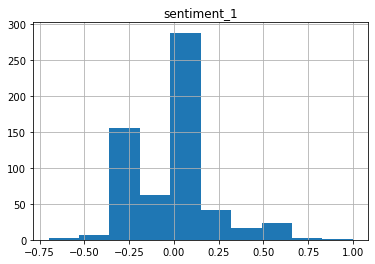

In [177]:
# the histogram gives a instant view of all sentiment , and changes from day to day
# depending on the news topic of the day.
df.hist(column='sentiment_1')

plt.show()

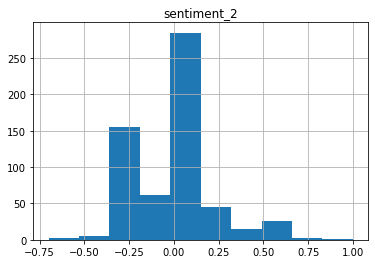

In [178]:
# The histogram give a visual indication of the sentiment, 
# we see the majority of the sentiment is around 0 on the x axis indicating neutral sentiment 
# in relation to Brexit and farming on the day the reading was taken. Previous readings 
# have tended to be mostly negative.
df.hist(column='sentiment_2')

plt.show()

## BAG OF WORDS

In [179]:
# Store the comments
X = df["tweets"]
y = df["sentiment_1"]

In [180]:
y.head()

Unnamed: 0
1358992730    1.000000
603077286     0.800000
1551416341    0.750000
125339572     0.700000
105269160     0.507143
Name: sentiment_1, dtype: float64

In [181]:
# Lamdba to categorise the sentiment to 0,1,2 groupings
y = y.apply(lambda x: 0 if x < -0.5 else (1 if x < 0.5 else 2))

In [182]:
y.head()

Unnamed: 0
1358992730    2
603077286     2
1551416341    2
125339572     2
105269160     2
Name: sentiment_1, dtype: int64

In [183]:
from nltk.corpus import stopwords
nltk.download('stopwords')

import string
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ambrosedesmond/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [184]:
# Store the stopwords into the object named as "stop_words"
# Stopwords are words which do not contain enough significance to be used without our algorithm
stop_words = stopwords.words('english')

# Store the string.punctuation into an object punct. Removing Punctuation: ‘,.*!’ and other 
# punctuation marks that are not really needed by the model
punct = string.punctuation

# Initialise an object using a method PorterStemmer.
# reducing words like ‘jumping, jumped, jump’ into its root word(also called stem)
stemmer = PorterStemmer()

In [185]:
import re

cleaned_data=[]

# For loop from first value to length(X), ^a-zA-Z means include small and capital case letters

for i in range(len(X)):
    message = re.sub('[^a-zA-Z]', ' ', X.iloc[i])
    message = message.lower().split()
    message = [stemmer.stem(word) for word in message if (word not in stop_words) and (word not in punct)]
    # we rejoin all the words back into a sentance again and append the sentances into a list
    message = ' '.join(message)
    cleaned_data.append(message)

In [186]:
X # this is the regular cleaned data, note I have full sentices with all the unnecessary words

Unnamed: 0
1358992730             hic334 The NFU position was that farmers inter...
603077286              natalieben UK farmers are being priced out by ...
1551416341             The headline doesnt do justice to the importan...
125339572                                   Good news httpstcoJijauzZpfG
105269160              JohnMellis francesca_geld  yet all the trade d...
                                             ...                        
1501716185234096129    NicholasTyrone Amen to that\n\nIt makes me ang...
1360497947297914880    jackiekemp A percentage of FarmersFinshing vot...
1497954762377113608    I find it really difficult to get excised abou...
3192252407             Brexit barriers are so unnecessary erryesFFSso...
22519204               No money for Elms means farmers will have no c...
Name: tweets, Length: 599, dtype: object

In [187]:
# Unnecessary (stop words) removed but meaning still intact. the stemer sometimes abbreviates words too
cleaned_data 

['hic nfu posit farmer interest would best serv stay eu yet farmer vote brexit',
 'natalieben uk farmer price supermarket farmer leav industri choic insolv govern happi trade deal australia nz undermin farmer even nz media realis would affect uk farmer brexit benefit cours',
 'headlin doesnt justic import complex make transit success biodivers climat resili ecosystem impact httpstcooov w khuu',
 'good news httpstcojijauzzpfg',
 'johnmelli francesca geld yet trade deal countri done nobodi seem complain uk farmer certainli got screw ukau trade agreement anoth brexit win',
 'chanc eu britain start relationship afresh realiti disproof brexit argument brexitli brexitbrokebritain httpstcoe jrsbd',
 'come eu cap opportun reshap agricultur amp food system rather prop farm system damag natur unsustain amp leav mani farmer close poverti httpstco sridyrv',
 'waltjack sainsburi tesco garethwynjon farmersweekli farmersguardian scottishfarm nfutweet natsheep bbcneandcumbria farminguk thefarmingforum

In [188]:
# Tokenization is the act of breaking up a sequence of strings into pieces such 
# as words, keywords, phrases, symbols and other elements called tokens
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate an object cv by calling a method named as CountVectorzer()
# here we are only taking 3K columns else the dataset will be too big
# one con here is the order of the words is lost so the meaning can be lost a little
# set stop words to names that dont indicate sentiment
cv    = CountVectorizer(max_features = 3000, stop_words = ['BREXIT'])

# convert the cleaneddata into the bag of words we want
X_fin = cv.fit_transform(cleaned_data).toarray()

# Display the rows and colums
X_fin.shape

(599, 2854)

In [189]:
# This is the feature vector just created
X_fin

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [190]:
# build the NLP model using the input and the output, use the Multinomial Naive Bayes
# model to figure out the relationship between the input and the output.
# its a supervised learning algorithm that works really well for text based data
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# Instantiate an object model by calling a method MultinomialNB()
model = MultinomialNB()

In [191]:
# Split the dataset into training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X_fin, y, test_size = 0.3)

In [192]:
# Train the model by calling a method fit()
model.fit(X_train,y_train)

MultinomialNB()

In [193]:
# Call predict() method
# To check how good our model is we first make predictions on the test set
y_pred = model.predict(X_test)

In [194]:
print(y_pred)

[1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1
 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1]


In [195]:
from sklearn.metrics import classification_report

# Instantiate a mthod named as Cla
cf = classification_report(y_test, y_pred)

# Display the values of an object cf
print(cf)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.95      0.92      0.93       170
           2       0.07      0.12      0.09         8

    accuracy                           0.88       180
   macro avg       0.34      0.35      0.34       180
weighted avg       0.90      0.88      0.89       180



## Feture Generation using TI-IDF

In [196]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create an object 'tf' by calling a method TfidfVectorizer()
tfidf = TfidfVectorizer(max_features = 3000)

# Train the dataset by calling a method fit_tranform() 
X_tfidf = tfidf.fit_transform(cleaned_data).toarray()

In [197]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# Instantiate an object model by calling a method MultinomialNB()
model_tdidf = MultinomialNB()

In [198]:
# Split the dataset into training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size = 0.3)

In [199]:
# Train the model by calling a method fit()
model_tdidf.fit(X_train, y_train)

MultinomialNB()

In [200]:
# Call predict() method
y_pred = model_tdidf.predict(X_test)

In [201]:
from sklearn.metrics import classification_report

# Instantiate a mthod named as Cla
cf = classification_report(y_test, y_pred)

# Display the values of an object cf
print(cf)

              precision    recall  f1-score   support

           1       0.93      1.00      0.96       167
           2       0.00      0.00      0.00        13

    accuracy                           0.93       180
   macro avg       0.46      0.50      0.48       180
weighted avg       0.86      0.93      0.89       180



# Analysis of irish milk production v weather

In [206]:
iedf = pd.read_csv("cork_weather_and_milk.csv")

In [207]:
iedf.head()

,date,rain,mintp,maxtp,soil,milk,fat,pro,month
0,2012-01-01,3.035484,4.877419,9.600000,6.917742,133.3,3.98,3.25,January
1,2012-02-01,1.462069,5.368966,9.468966,7.259483,236.6,4.06,3.24,February
2,2012-03-01,0.764516,5.277419,11.412903,8.621774,473.0,3.99,3.22,March
3,2012-04-01,2.753333,3.570000,10.550000,8.260833,637.3,3.81,3.32,April
4,2012-05-01,2.351613,7.406452,13.538710,11.976613,735.0,3.75,3.34,May


In [208]:
iedfml = iedf.set_index('date')
iedfml = iedfml.drop(['month'], axis = 1)
iedf.head()

,date,rain,mintp,maxtp,soil,milk,fat,pro,month
0,2012-01-01,3.035484,4.877419,9.600000,6.917742,133.3,3.98,3.25,January
1,2012-02-01,1.462069,5.368966,9.468966,7.259483,236.6,4.06,3.24,February
2,2012-03-01,0.764516,5.277419,11.412903,8.621774,473.0,3.99,3.22,March
3,2012-04-01,2.753333,3.570000,10.550000,8.260833,637.3,3.81,3.32,April
4,2012-05-01,2.351613,7.406452,13.538710,11.976613,735.0,3.75,3.34,May


In [209]:
# Function for scatter plot and model
def lin_regplot(X, y, model):
    """ function takes an X,y and plots against a given model"""
    plt.scatter(X, y, c = 'blue')
    plt.plot(X, model.predict(X), color = 'red', linewidth = 2)    
    return

In [210]:
# define standard scaler function
def scale_data(df,cols):
    std_scaler = StandardScaler()
    # save the index
    save_indx = df.index
    df_1 = std_scaler.fit_transform(df.to_numpy())
    # remake the data frame with my saved index. Need this to if want to make dummy variables later
    return pd.DataFrame(df_1, columns = cols, index = [save_indx])


In [211]:

############## Create a class named as 'LinearRegressionGD'
class LinearRegressionGD(object):
    """A class to iterate over a given linear regression and store the results in an array"""
    # the init method runs every time we icreate a new instance of the class
    # class is pre defined to iterate 20 with learning rate eta 0.001
    def __init__(self, eta = 0.001, n_iter = 20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        # makes an array of zeros with the shape and set up empty cost list
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

In [212]:
iedfml.head()

,rain,mintp,maxtp,soil,milk,fat,pro
date,,,,,,,
2012-01-01,3.035484,4.877419,9.600000,6.917742,133.3,3.98,3.25
2012-02-01,1.462069,5.368966,9.468966,7.259483,236.6,4.06,3.24
2012-03-01,0.764516,5.277419,11.412903,8.621774,473.0,3.99,3.22
2012-04-01,2.753333,3.570000,10.550000,8.260833,637.3,3.81,3.32
2012-05-01,2.351613,7.406452,13.538710,11.976613,735.0,3.75,3.34


In [213]:
scale_this = ['rain','mintp','maxtp','soil','milk','fat','pro']
iedfs = scale_data(iedfml,scale_this)

In [214]:
iedfs.head()

,rain,mintp,maxtp,soil,milk,fat,pro
date,,,,,,,
2012-01-01,-0.251295,-0.606181,-0.887761,-0.887041,-1.558402,-0.593939,-1.105200
2012-02-01,-1.044092,-0.457018,-0.920971,-0.808125,-1.181129,-0.315349,-1.153291
2012-03-01,-1.395568,-0.484799,-0.428283,-0.493540,-0.317748,-0.559116,-1.249473
2012-04-01,-0.393462,-1.002925,-0.646984,-0.576890,0.282308,-1.185944,-0.768564
2012-05-01,-0.595877,0.161269,0.110500,0.281170,0.639129,-1.394887,-0.672382


In [215]:
X = iedfs[['soil']].values
y = iedfs[['milk']].values
X.shape, y.shape

((108, 1), (108, 1))

In [216]:
# Reshape the (359, 1) to (359,) array for Machine Learning model
y = np.reshape(y, 108)

# Display the number of rows and columns
X.shape, y.shape

((108, 1), (108,))

In [217]:
# split the data into test train sets
X_train, X_test, y_train, y_test = (train_test_split(X,y, test_size = 0.2,random_state = 42))
X_train.shape ,y_train.shape,X_test.shape,y_test.shape

((86, 1), (86,), (22, 1), (22,))

# LinearRegression

In [218]:
# First I will make a table to store my results.
# I will be using the tabulate library
table =[]

mse_reg = 0.36950086407284977
rmse_reg = 0.6078658273606519


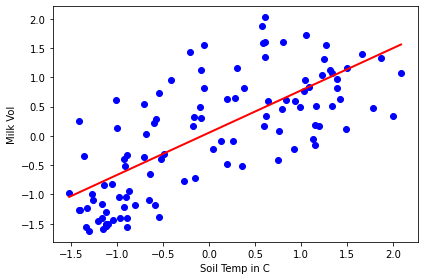

In [219]:
# Call the method lin_regplot()
A = iedfs[['soil']].values
b = iedfs['milk'].values

reg = LinearRegression()
reg.fit(X_train ,y_train)

y_pred = reg.predict(X_test)
mse_reg = MSE(y_test,y_pred)
rmse_reg = mse_reg**(1/2)

print (f"mse_reg = {mse_reg}")
print (f"rmse_reg = {rmse_reg}")

lin_regplot(A[sort_idx], b[sort_idx], reg)
plt.xlabel('Soil Temp in C')
plt.ylabel(f'Milk Vol')
plt.tight_layout()
plt.savefig("soil_milk_lr.png", dpi=300)
# plt.savefig('./figures/gradient_fit.png', dpi=300)
plt.show()

result = ["LinearRegression",mse_reg,rmse_reg]
table.append(result)

# DecisionTreeRegressor

mse_dtr = 0.25131770490769956
rmse_dtr = 0.5013159731224406


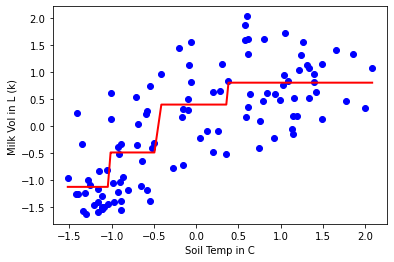

In [220]:
#  DecisionTreeRegressor on rain feature and plot
# Store the feature or attribute values in X and y


# Instantiate theDecisionTreeRegressor and assign it to tree
dtr = DecisionTreeRegressor(max_depth = 2,min_samples_leaf=0.1,random_state=3)
dtr.fit(X_train,y_train)
y_pred = dtr.predict(X_test)
mse_dtr = MSE(y_test,y_pred)
rmse_dtr = mse_dtr**(1/2)

print (f"mse_dtr = {mse_dtr}")
print (f"rmse_dtr = {rmse_dtr}")
sort_idx = A.flatten().argsort()

lin_regplot(A[sort_idx], b[sort_idx], dtr)
plt.xlabel('Soil Temp in C')
plt.ylabel(f'Milk Vol in L (k) ')
plt.savefig('DTR_soil_milk.png', dpi = 300)
plt.show()

result = ["DecisionTreeRegressor",mse_dtr,rmse_dtr]
table.append(result)

# RandomForestRegressor

mse_rfr = 0.24943853987190778
rmse_rfr = 0.49943822427994816


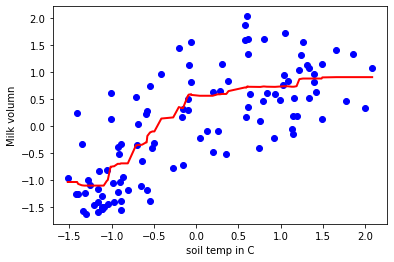

In [221]:

rf = RandomForestRegressor(max_depth=2,random_state=42)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
mse_rfr = MSE(y_test,y_pred)
rmse_rfr = mse_rfr**(1/2)
print (f"mse_rfr = {mse_rfr}")
print (f"rmse_rfr = {rmse_rfr}")

lin_regplot(A[sort_idx], b[sort_idx], rf)
plt.xlabel('soil temp in C')
plt.ylabel(f'Milk volumn')
plt.savefig('DT_milk_soil.png', dpi = 300)
plt.show()

result = ["RandomForestRegressor",mse_rfr,rmse_rfr]
table.append(result)

In [ ]:
# pip install tabulate

In [223]:
# Print table with results

from tabulate import tabulate
print(tabulate(table, headers=["ML Model","mse", "rmse"]))

ML Model                    mse      rmse
---------------------  --------  --------
LinearRegression       0.369501  0.607866
DecisionTreeRegressor  0.251318  0.501316
RandomForestRegressor  0.249439  0.499438


# GridSearchCV

In [153]:
# will use GridSearch_CV to find the best params and score for the RandonForestRegressor model
# set up the params I will use

parameters = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [1,2,3,4],
}
regr = RandomForestRegressor(random_state=0)

rfr_cv = GridSearchCV(regr, parameters)
rfr_cv.fit(X_train, y_train)
rmse_rfr_cv = rfr_cv.best_score_
print(f' The best Parameters are : {rfr_cv.best_params_}')
print (f' The best score was {rfr_cv.best_score_}')



 The best Parameters are : {'max_depth': 2, 'n_estimators': 100}
 The best score was 0.4392300274502972


## Time series on milk production.

In [ ]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Dense, SimpleRNN # for creating regular densely-connected NN layers and RNN layers

# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import math # to help with data reshaping of the data

# Sklearn
import sklearn # for model evaluation
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import mean_squared_error # for model evaluation metrics
from sklearn.preprocessing import MinMaxScaler # for feature scaling

# Visualization
import plotly 
import plotly.express as px
import plotly.graph_objects as go
print('plotly: %s' % plotly.__version__) # print version